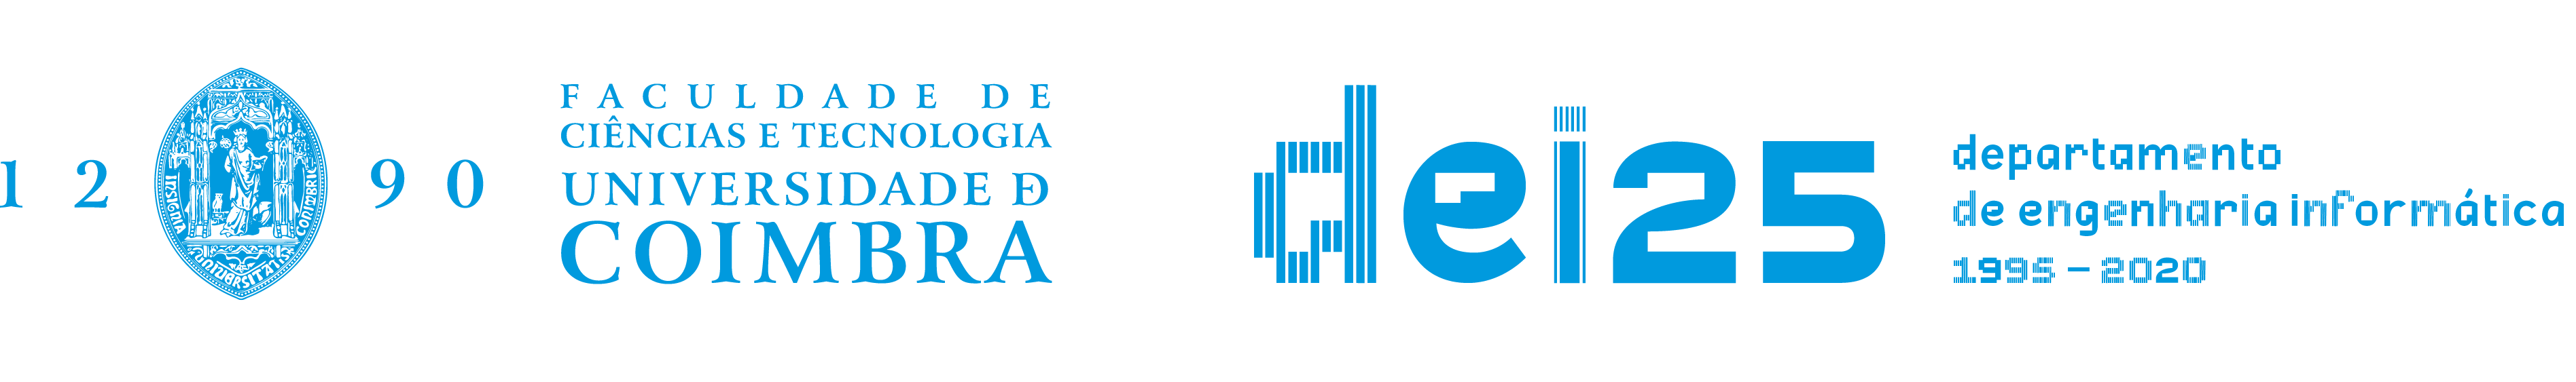

# **Projeto I - Classificação de doenças dermatológicas através de redes neuronais artificiais**

<h3><strong>Mestrado em Engenharia e Ciência de Dados | 2024-2025</strong></h3>
<h3><strong>Aprendizagem Computacional Avançada</strong></h3>

Eduardo Soares das Neves Cardoso, nº 2021226956

Matilde Martins Reis, nº 2021237887

_______

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
import torchvision.transforms as transforms
import plotly.express as px
import torch.nn.functional as F

#%pip install medmnist
import medmnist
from medmnist import INFO

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### **Preparação do Dataset**

O dataset utilizado é o conjunto de dados **DermaMNIST**, que corresponde a várias imagens dermatológicas, divididas em 7 classes. As imagens possuem dimensão 28x28 e três canais de cor (RGB).

In [ ]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels'] # nº de canais da imagem (RGB ou grayscale)
n_classes = len(info['label']) # nº de classes

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(), # Transforma as imagens em Tensors e normaliza-as do intervalo [0, 255] para [0, 1]
])

# Separar os dados em conjuntos de treino, validação e teste
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# Colocar os dados no formato DataLoader
# shuffle = True ajuda na generalização, evitanto que o modelo memorize a ordem das amostras durante o treino
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
print(train_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


In [ ]:
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 2005
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


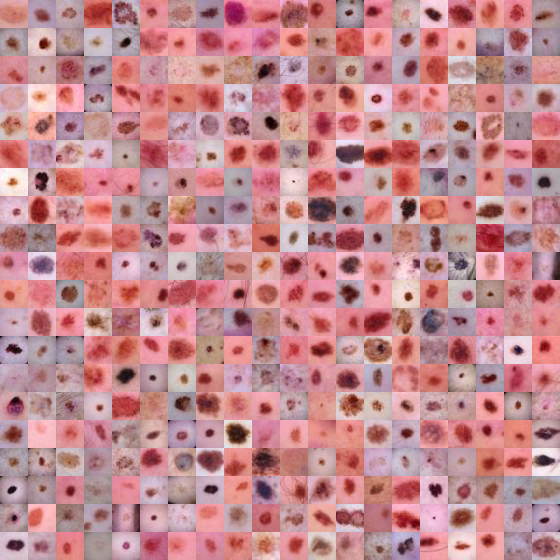

In [ ]:
# Visualizar algumas das imagens

train_dataset.montage(length=20)

Por razões de maior facilidade na manipulação dos dados, decidimos separar os conjuntos de dados em X (os tensors das imagens) e Y (as classes respetivas):

In [ ]:
def create_x_y(loader):
    X = []
    y = []

    for images, labels in loader:
        X.append(images)
        y.append(labels.squeeze())

    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)

    return X, y

In [ ]:
X_train, y_train = create_x_y(train_loader)
X_val, y_val = create_x_y(validation_loader)
X_test, y_test = create_x_y(test_loader)

print(f'Conjunto de treino:    X: {X_train.shape} Y: {y_train.shape}')
print(f'Conjunto de validação: X: {X_val.shape} Y: {y_val.shape}')
print(f'Conjunto de teste:     X: {X_test.shape} Y: {y_test.shape}')

Conjunto de treino:    X: torch.Size([7007, 3, 28, 28]) Y: torch.Size([7007])
Conjunto de validação: X: torch.Size([1003, 3, 28, 28]) Y: torch.Size([1003])
Conjunto de teste:     X: torch.Size([2005, 3, 28, 28]) Y: torch.Size([2005])


#### Balanceamento do dataset

É importante assegurar que o dataset está balanceado, isto é, que a distribuição das amostras pelas várias classes seja equilibrada, de modo a que os modelos tenham uma boa performance. Assim, o passo seguinte que realizámos foi verificar o balanceamento dos dados:

In [ ]:
# Número de amostras em cada classe
labels_count = np.array([[i, (y_train == i).sum()] for i in range(7)])

# Visualizar distribuição das classes
fig = px.pie(values=labels_count[:,1], names=info['label'].values(), color_discrete_sequence=px.colors.sequential.PuBu[::-1])

fig.update_layout(width=760,
                  height=400,
                  title = 'Balanceamento do dataset',
                  title_font = dict(size = 20, color = 'black'),
                  legend=dict(
                      title=dict(text='Classes:', font=dict(size=14, color='black')),
                      font=dict(size=12, color='black')),
                  margin=dict(t=50, b=20)
                )
fig.show()

# Verificar número de amostras em cada classe
labels_count = labels_count[np.argsort(labels_count[:, 1])[::-1]]

print("Número de amostras por classe:")
for label, n in labels_count:
    print(f"Classe {label}: {n} amostras")

Número de amostras por classe:
Classe 5: 4693 amostras
Classe 4: 779 amostras
Classe 2: 769 amostras
Classe 1: 359 amostras
Classe 0: 228 amostras
Classe 6: 99 amostras
Classe 3: 80 amostras


Através do gráfico acima percebemos que este dataset está altamente desbalanceado, variando entre 80 imagens para a classe 0 e 4693 para a classe 5. Para garantir que os modelos sejam capazes de classificar corretamente todas as classes, é necessário aplicar técnicas que ajudem a resolver este problema.

Desta forma, decidimos implementar três métodos em conjunto:
 - **oversampling** das classes 0, 1, 2, 3, 4 e 6, através do algoritmo SMOTE. Aumentámos estas classes em proporções diferentes, pois o nosso objetivo é apenas que as amostras de cada classe estejam mais próximas em quantidade umas das outras, ao mesmo tempo que aumentamos a quantidade de dados disponíveis.

 - **undersampling** da classe 5. De modo a não ser necessário gerar um número tão elevado de imagens para igualar a distribuição das restantes classes à desta, removemos algumas das suas amostras (removemos apenas 500 das 4693, para não perder demasiada informação);

 - cálculo de **pesos** a atribuir a cada classe. Como após as duas técnicas anteriores o dataset não ficou totalmente balanceado, ao atribuir pesos mais elevados às classes minoritárias no cálculo da loss pretendemos que erros na classificação dessas classes sejam mais penalizados.

In [ ]:
# Oversampling
os_dict = {
    0: 2500,
    1: 2500,
    2: 3000,
    3: 1500,
    4: 3000,
    5: labels_count[0,1], # mantém-se o valor original
    6: 1500}

oversample = SMOTE(sampling_strategy=os_dict)
oversampling_X, oversampling_Y = oversample.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

oversampling_X = torch.tensor(oversampling_X).view(-1, 3, 28, 28).float()
oversampling_Y = torch.tensor(oversampling_Y).long()

print('OS_X: %s OS_y: %s' %(oversampling_X.shape, oversampling_Y.shape))

# Undersampling
us_dict = {
    0: 2500,
    1: 2500,
    2: 3000,
    3: 1500,
    4: 3000,
    5: 3500, # retirar algumas amostras da classe 5
    6: 1500}

oversampling_X_flat = oversampling_X.view(oversampling_X.shape[0], -1)  # (n_samples, 28*28*3)

undersample = RandomUnderSampler(sampling_strategy=us_dict)
undersampled_X, undersampled_y = undersample.fit_resample(oversampling_X_flat, oversampling_Y)

X_train = torch.tensor(undersampled_X).view(-1, 3, 28, 28).float()
y_train = torch.tensor(undersampled_y).long()

print('US_X: %s US_y: %s' % (X_train.shape, y_train.shape))

OS_X: torch.Size([18693, 3, 28, 28]) OS_y: torch.Size([18693])
US_X: torch.Size([17500, 3, 28, 28]) US_y: torch.Size([17500])


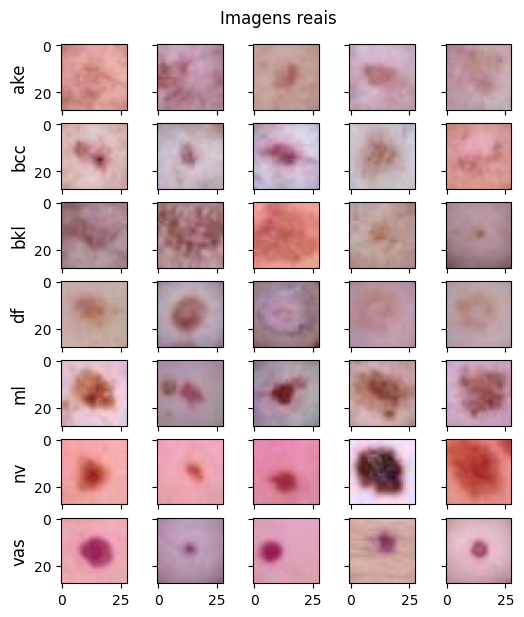

In [ ]:
# Visualização de imagens originais
fig, ax = plt.subplots(7, 5)
fig.set_figheight(7)
fig.set_figwidth(6)
plt.suptitle("Imagens reais", y=0.93)

labels = ['ake', 'bcc' , 'bkl', 'df', 'ml', 'nv', 'vas']

for classes in range(7):
  for i, inx in enumerate(np.where(y_train==classes)[0][:5]):

    image = X_train[inx].permute(1, 2, 0).numpy()
    image = (image*255).astype('uint8')

    ax[classes,i].imshow(image)
    ax[classes,i].set_ylabel(labels[classes],fontsize = 12)
    ax[classes,i].label_outer()

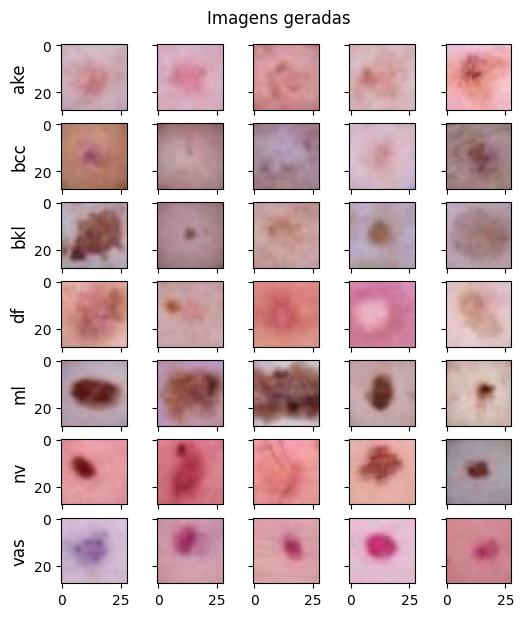

In [ ]:
# Visualização de imagens geradas através de SMOTE
fig, ax = plt.subplots(7, 5)
fig.set_figheight(7)
fig.set_figwidth(6)
plt.suptitle("Imagens geradas", y=0.93)

labels = ['ake', 'bcc' , 'bkl', 'df', 'ml', 'nv', 'vas']

for classes in range(7):
  for i, inx in enumerate(np.where(y_train==classes)[0][-5:]):

    image = X_train[inx].permute(1, 2, 0).numpy()
    image=(image * 255).astype('uint8')

    ax[classes,i].imshow(image)
    ax[classes,i].set_ylabel(labels[classes],fontsize = 12)
    ax[classes,i].label_outer()

In [ ]:
# Calcular pesos para cada classe

total_amostras = len(y_train)

labels_count = np.bincount(y_train.numpy())

pesos = []

for i in range(len(labels_count)):
    peso = total_amostras / labels_count[i]
    pesos.append(peso)

pesos = torch.tensor(pesos, dtype=torch.float32)

print(f"Peso de cada classe: {pesos}")

Peso de cada classe: tensor([ 7.0000,  7.0000,  5.8333, 11.6667,  5.8333,  5.0000, 11.6667])


### **Treino e Avaliação**

A forma como é feito o treino dos modelos é igual para ambos (assim como a avaliação). Por isso, definimos uma única função para treinar os modelos e outra para avaliar a performance:

In [ ]:
# Treino do modelo
def fit(X_train, y_train, X_val, y_val, nn, loss_func, optimizer, n_epochs, batch_size=128):

    nn = nn.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    X_val = X_val.to(device)
    y_val = y_val.to(device)

    # Conjunto de treino
    train_dataset = data.TensorDataset(X_train, y_train)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Conjunto de validação
    val_dataset = data.TensorDataset(X_val, y_val)
    val_loader = data.DataLoader(val_dataset, batch_size=2*batch_size, shuffle=False)

    # Loss
    loss_values = []
    val_loss_values = []

    # Accuracy
    train_acc = []
    val_acc = []

    for epoch in range(n_epochs):
        train_loss = 0
        acc_t = 0
        it = 0

        for batch in train_loader:
            X_batch = batch[0].to(device)
            y_batch = batch[1].long().view(-1).to(device)

            # Forward pass
            outputs = nn(X_batch)
            loss = loss_func(outputs, y_batch)
            train_loss += loss.item()

            # Backward e otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to("cpu")
            acc_t += accuracy_score(y_batch.to("cpu").numpy(), predicted.numpy())
            it += 1

        loss_values.append(train_loss)
        train_acc.append(acc_t/it)


        # Calcular loss e accuracy dos dados de validação
        val_loss = 0
        acc_v = 0
        it = 0

        for batch in val_loader:
            X_batch = batch[0].to(device)
            y_batch = batch[1].long().to(device)

            outputs = nn(X_batch)
            loss = loss_func(outputs, y_batch)
            val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to("cpu")
            acc_v += accuracy_score(y_batch.to("cpu").numpy(), predicted.numpy())
            it += 1

        print ('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
        val_loss_values.append(val_loss)
        val_acc.append(acc_v/it)

    return loss_values, val_loss_values, train_acc, val_acc, nn.to("cpu")

In [ ]:
# Avaliação do modelo
def evaluate_network(net, X, y):
    net.eval()
    X = X.to(device)
    net = net.to(device)

    # Prever as classes dos dados de teste
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Converter os tensors para arrays numpy
    predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Calcular métricas de avaliação
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')
    accuracy = accuracy_score(test_target_np, predicted_np)

    print('Matriz de Confusão:\n', conf_mat)
    print('F1 Score: ', np.round(f1, 4))
    print('Accuracy: ', np.round(accuracy, 4))

Decidimos ainda criar uma função para visualizar a loss e accuracy ao longo do treino, de modo a observar a sua evolução:

In [ ]:
def viz_loss_acc(n_epochs, train_loss, val_loss, train_acc, val_acc):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    # Loss
    ax1.plot(np.arange(n_epochs), train_loss, label='train loss')
    ax1.plot(np.arange(n_epochs), val_loss, label='val loss')

    ax1.set_title('Loss')
    ax1.set_ylim(0,100)
    ax1.set_ylabel('loss/accuracy')
    ax1.set_xlabel('epochs')
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid()

    # Accuracy
    ax2.plot(np.arange(n_epochs), train_acc, label='train accuracy')
    ax2.plot(np.arange(n_epochs), val_acc, label='val accuracy')

    ax2.set_title('Accuracy')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('loss/accuracy')
    ax2.set_xlabel('epochs')
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid()

    plt.show()

### **Modelo 1 - Multi-Layer Perceptron**

O MLP é uma rede neuronal constituída por diversas camadas de neurónios, organizadas de forma sequencial, que permitem realizar a classificação de um conjunto de dados.

Para que o MLP classifique imagens, é necessário converter os nossos dados do formato 3D para 1D:

In [ ]:
def flatten_data(X):
    X_flatten = X.flatten(1)

    return X_flatten

A seguir definimos uma classe para implementar o MLP:

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes=7, activation="relu"):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0])) # Input Layer

            if activation == "relu":
                self.activations.append(nn.ReLU())
            elif activation == "sigmoid":
                self.activations.append(nn.Sigmoid())

            for i in range(1, len(hidden_sizes)):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i])) # Adicionar Hidden Layers

                if activation == "relu":
                    self.activations.append(nn.ReLU())
                elif activation == "sigmoid":
                    self.activations.append(nn.Sigmoid())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes)) # Output Layer

    def forward(self, x):
        for i in range(len(self.activations)):
            x = self.activations[i](self.layers[i](x))

        x = self.layers[-1](x)
        return x

Com o modelo definido, procedemos à fase de experimentação, na qual variámos vários parâmetros com o objetivo de obter bons resultados.

#### 1ª Experiência

In [ ]:
x_train_flatten = flatten_data(X_train)

# Parâmetros
epochs = 300
batch_size = 256
hidden_layer_sizes = (512,512,512)
learning_rate = 0.0001

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.Adam(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/300], Train Loss: 129.5095, Val Loss: 3.1654
Epoch [2/300], Train Loss: 119.1524, Val Loss: 3.2793
Epoch [3/300], Train Loss: 115.1070, Val Loss: 2.9362
Epoch [4/300], Train Loss: 109.9311, Val Loss: 3.0527
Epoch [5/300], Train Loss: 104.8580, Val Loss: 2.9753
Epoch [6/300], Train Loss: 99.6734, Val Loss: 2.6967
Epoch [7/300], Train Loss: 96.4665, Val Loss: 2.5643
Epoch [8/300], Train Loss: 93.7586, Val Loss: 3.1165
Epoch [9/300], Train Loss: 91.2317, Val Loss: 2.4387
Epoch [10/300], Train Loss: 89.4610, Val Loss: 2.6470
Epoch [11/300], Train Loss: 87.1682, Val Loss: 2.4191
Epoch [12/300], Train Loss: 85.8154, Val Loss: 2.4398
Epoch [13/300], Train Loss: 84.6049, Val Loss: 2.3104
Epoch [14/300], Train Loss: 84.2652, Val Loss: 2.4488
Epoch [15/300], Train Loss: 82.7071, Val Loss: 2.8856
Epoch [16/300], Train Loss: 81.9706, Val Loss: 2.5550
Epoch [17/300], Train Loss: 81.1411, Val Loss: 2.5434
Epoch [18/300], Train Loss: 80.1237, Val Loss: 2.4164
Epoch [19/300], Train Loss: 78.5

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2354  134    0    0    1    0   11]
 [   1 2490    0    0    1    2    6]
 [  90  552 1976    4  103  237   38]
 [   3   38    0 1459    0    0    0]
 [  48   62   11    2 2762  106    9]
 [  24  131   61    4  219 3018   43]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.8871
Accuracy:  0.8891

Avaliação com os dados de teste:
Matriz de Confusão:
 [[  22   26    4    2    5    5    2]
 [   6   70    4    2    4   10    7]
 [  20   44   58    3   47   48    0]
 [   1   11    2    7    0    2    0]
 [  15   14   13    1  104   67    9]
 [  17   67   37    4  153 1043   20]
 [   0    2    1    0    1    3   22]]
F1 Score:  0.6767
Accuracy:  0.6613


#### 2ª Experiência

In [ ]:
# Parâmetros
epochs = 300
batch_size = 256
hidden_layer_sizes = (1024,1024,512)
learning_rate = 0.0001

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.MultiMarginLoss(weight=pesos.to(device))
otim = optim.Adam(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/300], Train Loss: 352.2447, Val Loss: 7.0633
Epoch [2/300], Train Loss: 286.5743, Val Loss: 6.9759
Epoch [3/300], Train Loss: 253.9150, Val Loss: 6.8439
Epoch [4/300], Train Loss: 229.5579, Val Loss: 5.3274
Epoch [5/300], Train Loss: 207.4510, Val Loss: 5.5122
Epoch [6/300], Train Loss: 196.4734, Val Loss: 5.2657
Epoch [7/300], Train Loss: 190.4899, Val Loss: 4.0614
Epoch [8/300], Train Loss: 177.2774, Val Loss: 5.5333
Epoch [9/300], Train Loss: 175.0893, Val Loss: 3.9252
Epoch [10/300], Train Loss: 167.4675, Val Loss: 4.0213
Epoch [11/300], Train Loss: 161.4628, Val Loss: 4.0514
Epoch [12/300], Train Loss: 155.9355, Val Loss: 4.3674
Epoch [13/300], Train Loss: 151.2132, Val Loss: 4.0571
Epoch [14/300], Train Loss: 152.4704, Val Loss: 3.6045
Epoch [15/300], Train Loss: 145.0482, Val Loss: 3.6169
Epoch [16/300], Train Loss: 136.0356, Val Loss: 3.9230
Epoch [17/300], Train Loss: 143.3971, Val Loss: 3.7680
Epoch [18/300], Train Loss: 132.5251, Val Loss: 4.2779
Epoch [19/300], Tra

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2406    6    9   55   13   11    0]
 [  28 2187   89  133   35   26    2]
 [  19    3 2832   22   69   33   22]
 [   0    0    0 1500    0    0    0]
 [   0    0    9    2 2972   16    1]
 [  11   11  139   21  326 2964   28]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9346
Accuracy:  0.9349

Avaliação com os dados de teste:
Matriz de Confusão:
 [[ 29   5  14   5   6   6   1]
 [  9  37  21  12   9   9   6]
 [ 12   5 109   7  59  28   0]
 [  2   3   2  10   4   2   0]
 [  5   2  23   2 126  60   5]
 [  9  15  75  11 221 995  15]
 [  1   0   1   0   2   3  22]]
F1 Score:  0.6873
Accuracy:  0.6623


#### 3ª Experiência

In [ ]:
# Parâmetros
epochs = 400
batch_size = 256
hidden_layer_sizes = (1024,1024,1024)
learning_rate = 0.0001

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="sigmoid")

loss_func = nn.MultiMarginLoss(weight=pesos.to(device))
otim = optim.RMSprop(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/400], Train Loss: 388.9273, Val Loss: 9.3757
Epoch [2/400], Train Loss: 324.3930, Val Loss: 6.9855
Epoch [3/400], Train Loss: 315.0236, Val Loss: 8.4072
Epoch [4/400], Train Loss: 306.3753, Val Loss: 5.7192
Epoch [5/400], Train Loss: 296.7936, Val Loss: 6.8404
Epoch [6/400], Train Loss: 286.6534, Val Loss: 5.8643
Epoch [7/400], Train Loss: 277.9675, Val Loss: 8.3661
Epoch [8/400], Train Loss: 268.6729, Val Loss: 6.0748
Epoch [9/400], Train Loss: 259.3798, Val Loss: 5.0452
Epoch [10/400], Train Loss: 249.9486, Val Loss: 6.4327
Epoch [11/400], Train Loss: 245.8223, Val Loss: 6.0881
Epoch [12/400], Train Loss: 238.0978, Val Loss: 6.9200
Epoch [13/400], Train Loss: 233.4524, Val Loss: 5.4022
Epoch [14/400], Train Loss: 229.0339, Val Loss: 5.7246
Epoch [15/400], Train Loss: 225.5637, Val Loss: 6.7962
Epoch [16/400], Train Loss: 221.9543, Val Loss: 5.9259
Epoch [17/400], Train Loss: 218.7208, Val Loss: 6.2281
Epoch [18/400], Train Loss: 216.1229, Val Loss: 5.9306
Epoch [19/400], Tra

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2266   22   67   82   52    3    8]
 [ 699 1303  144  212  106   12   24]
 [ 333   60 1977  101  407   88   34]
 [  61    1    6 1425    2    5    0]
 [ 155   30  397   43 2300   64   11]
 [  77   71  450   60  751 2054   37]
 [  21   86    9    3   35    4 1342]]
F1 Score:  0.7204
Accuracy:  0.7238

Avaliação com os dados de teste:
Matriz de Confusão:
 [[ 36   8  10   7   4   0   1]
 [ 26  43   8  12   7   2   5]
 [ 34   4 119  13  42   8   0]
 [  5   3   1  10   2   2   0]
 [ 12   6  39  11 138  11   6]
 [ 38  37 162  26 317 751  10]
 [  2   3   1   2   4   2  15]]
F1 Score:  0.6038
Accuracy:  0.5546


#### 4ª Experiência

In [ ]:
# Parâmetros
epochs = 350
batch_size = 256
hidden_layer_sizes = (1024,1024)
learning_rate = 0.01

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.SGD(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/350], Train Loss: 133.3989, Val Loss: 3.8912
Epoch [2/350], Train Loss: 132.3222, Val Loss: 3.8130
Epoch [3/350], Train Loss: 131.1271, Val Loss: 3.7532
Epoch [4/350], Train Loss: 129.6724, Val Loss: 3.6747
Epoch [5/350], Train Loss: 127.9135, Val Loss: 3.5541
Epoch [6/350], Train Loss: 125.9296, Val Loss: 3.4906
Epoch [7/350], Train Loss: 123.9238, Val Loss: 3.4647
Epoch [8/350], Train Loss: 122.1246, Val Loss: 3.4443
Epoch [9/350], Train Loss: 120.6361, Val Loss: 3.3070
Epoch [10/350], Train Loss: 119.2174, Val Loss: 3.2596
Epoch [11/350], Train Loss: 118.2146, Val Loss: 2.9907
Epoch [12/350], Train Loss: 117.1618, Val Loss: 3.2853
Epoch [13/350], Train Loss: 116.1868, Val Loss: 3.4231
Epoch [14/350], Train Loss: 115.2712, Val Loss: 3.1999
Epoch [15/350], Train Loss: 114.2320, Val Loss: 2.8726
Epoch [16/350], Train Loss: 113.5068, Val Loss: 3.4106
Epoch [17/350], Train Loss: 112.8023, Val Loss: 3.1145
Epoch [18/350], Train Loss: 112.0957, Val Loss: 3.4333
Epoch [19/350], Tra

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[1316   35  483  193  430   38    5]
 [ 102 1264  501  228  322   35   48]
 [  37   21 2081   52  573  219   17]
 [   1    0   30 1444   22    3    0]
 [  12    4  217   24 2594  145    4]
 [  10   20  240   15  695 2494   26]
 [   0    0    9    0    4   17 1470]]
F1 Score:  0.722
Accuracy:  0.7236

Avaliação com os dados de teste:
Matriz de Confusão:
 [[ 15   8  20   4  16   2   1]
 [ 10  23  25  16  14   5  10]
 [  5   1 115  10  65  24   0]
 [  1   2   4   7   5   4   0]
 [  0   1  34   3 152  29   4]
 [  3  12 109   9 307 885  16]
 [  0   1   2   0   4   3  19]]
F1 Score:  0.6417
Accuracy:  0.6065


#### 5ª Experiência

In [ ]:
# Parâmetros
epochs = 400
batch_size = 512
hidden_layer_sizes = (1024,1024)
learning_rate = 0.05

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.SGD(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/400], Train Loss: 67.4205, Val Loss: 2.0274
Epoch [2/400], Train Loss: 66.0249, Val Loss: 1.8978
Epoch [3/400], Train Loss: 64.1440, Val Loss: 2.3332
Epoch [4/400], Train Loss: 63.5455, Val Loss: 2.0235
Epoch [5/400], Train Loss: 61.9545, Val Loss: 1.7007
Epoch [6/400], Train Loss: 61.4347, Val Loss: 1.7933
Epoch [7/400], Train Loss: 60.5629, Val Loss: 1.7849
Epoch [8/400], Train Loss: 60.0295, Val Loss: 1.4138
Epoch [9/400], Train Loss: 59.2827, Val Loss: 1.9213
Epoch [10/400], Train Loss: 58.9367, Val Loss: 1.9034
Epoch [11/400], Train Loss: 58.7009, Val Loss: 1.3442
Epoch [12/400], Train Loss: 58.2152, Val Loss: 1.7032
Epoch [13/400], Train Loss: 58.2617, Val Loss: 1.5667
Epoch [14/400], Train Loss: 57.6055, Val Loss: 1.3596
Epoch [15/400], Train Loss: 58.0418, Val Loss: 2.0424
Epoch [16/400], Train Loss: 57.2742, Val Loss: 1.3724
Epoch [17/400], Train Loss: 57.2167, Val Loss: 1.5573
Epoch [18/400], Train Loss: 55.9618, Val Loss: 1.6951
Epoch [19/400], Train Loss: 56.5634, 

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[1168  233 1042    7   28    3   19]
 [  17 1572  696   23   30   37  125]
 [  19   48 2847    6   19   10   51]
 [   3   18   86 1393    0    0    0]
 [   7   18  857   22 1949   95   52]
 [   4   49  921   14  189 2222  101]
 [   0    0    6    0    0    0 1494]]
F1 Score:  0.731
Accuracy:  0.7226

Avaliação com os dados de teste:
Matriz de Confusão:
 [[ 12  11  32   3   4   3   1]
 [  1  38  40   6   2   6  10]
 [  6   9 158   2  27  15   3]
 [  0   3  13   4   1   1   1]
 [  5   2  83   4  83  39   7]
 [  3  22 355   4 115 802  40]
 [  0   1   5   0   1   4  18]]
F1 Score:  0.5999
Accuracy:  0.5561


#### 6ª Experiência

In [ ]:
# Parâmetros
epochs = 300
batch_size = 256
hidden_layer_sizes = (1024,512,512,512)
learning_rate = 0.0001

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.Adam(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/300], Train Loss: 129.0664, Val Loss: 3.4480
Epoch [2/300], Train Loss: 119.5346, Val Loss: 3.2732
Epoch [3/300], Train Loss: 114.9648, Val Loss: 2.9819
Epoch [4/300], Train Loss: 110.2323, Val Loss: 2.8516
Epoch [5/300], Train Loss: 104.0874, Val Loss: 3.0149
Epoch [6/300], Train Loss: 99.7722, Val Loss: 2.5930
Epoch [7/300], Train Loss: 94.9977, Val Loss: 2.6949
Epoch [8/300], Train Loss: 91.9869, Val Loss: 2.9817
Epoch [9/300], Train Loss: 89.2671, Val Loss: 2.6608
Epoch [10/300], Train Loss: 88.8661, Val Loss: 2.6853
Epoch [11/300], Train Loss: 85.4116, Val Loss: 2.5329
Epoch [12/300], Train Loss: 84.1236, Val Loss: 2.9569
Epoch [13/300], Train Loss: 84.3661, Val Loss: 2.3183
Epoch [14/300], Train Loss: 82.3301, Val Loss: 2.3939
Epoch [15/300], Train Loss: 81.8533, Val Loss: 2.6928
Epoch [16/300], Train Loss: 81.0410, Val Loss: 2.7106
Epoch [17/300], Train Loss: 80.2759, Val Loss: 2.4226
Epoch [18/300], Train Loss: 78.4416, Val Loss: 2.4103
Epoch [19/300], Train Loss: 77.2

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2494    4    2    0    0    0    0]
 [   2 2480    2    9    1    6    0]
 [   7   27 2875    3   28   56    4]
 [   0    0    0 1500    0    0    0]
 [   1    2   29    0 2890   76    2]
 [  10   35   95    3  129 3213   15]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9685
Accuracy:  0.9687

Avaliação com os dados de teste:
Matriz de Confusão:
 [[  31   11   11    2    5    5    1]
 [  12   50   17    5    2   10    7]
 [  10   20  100    3   32   55    0]
 [   0    4    6    9    1    3    0]
 [   7    6   30    1   90   84    5]
 [  11   28   80    4  131 1078    9]
 [   1    0    2    0    1    4   21]]
F1 Score:  0.698
Accuracy:  0.6878


#### 7ª Experiência

In [ ]:
x_train_flatten = flatten_data(X_train)

# Parâmetros
epochs = 300
batch_size = 256
hidden_layer_sizes = (512,512,512,512,512)
learning_rate = 0.0001

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.Adam(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/300], Train Loss: 130.1728, Val Loss: 3.4140
Epoch [2/300], Train Loss: 120.5448, Val Loss: 3.6708
Epoch [3/300], Train Loss: 115.8483, Val Loss: 3.1348
Epoch [4/300], Train Loss: 112.4804, Val Loss: 3.0723
Epoch [5/300], Train Loss: 107.4636, Val Loss: 3.1568
Epoch [6/300], Train Loss: 102.7685, Val Loss: 2.6706
Epoch [7/300], Train Loss: 99.4951, Val Loss: 2.6715
Epoch [8/300], Train Loss: 95.2506, Val Loss: 2.4956
Epoch [9/300], Train Loss: 92.2781, Val Loss: 2.7154
Epoch [10/300], Train Loss: 88.4984, Val Loss: 2.8336
Epoch [11/300], Train Loss: 87.0543, Val Loss: 2.4437
Epoch [12/300], Train Loss: 88.9513, Val Loss: 2.4814
Epoch [13/300], Train Loss: 83.1335, Val Loss: 2.2628
Epoch [14/300], Train Loss: 84.2271, Val Loss: 2.3157
Epoch [15/300], Train Loss: 82.1308, Val Loss: 2.5589
Epoch [16/300], Train Loss: 81.1733, Val Loss: 2.9308
Epoch [17/300], Train Loss: 81.0003, Val Loss: 2.3952
Epoch [18/300], Train Loss: 78.6868, Val Loss: 2.3899
Epoch [19/300], Train Loss: 79.

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2500    0    0    0    0    0    0]
 [   2 2492    3    0    0    3    0]
 [   0    2 2992    0    1    5    0]
 [   1    1    1 1497    0    0    0]
 [   0    0    4    0 2991    5    0]
 [   4   16   46    1   58 3375    0]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9912
Accuracy:  0.9913

Avaliação com os dados de teste:
Matriz de Confusão:
 [[  30   12    9    3    5    7    0]
 [  11   55   12    2    5   16    2]
 [  14   11  105    3   30   57    0]
 [   2    6    4    7    0    4    0]
 [   4    7   36    2   93   80    1]
 [   8   20   62    1  136 1112    2]
 [   2    1    1    0    4    5   16]]
F1 Score:  0.7142
Accuracy:  0.7072


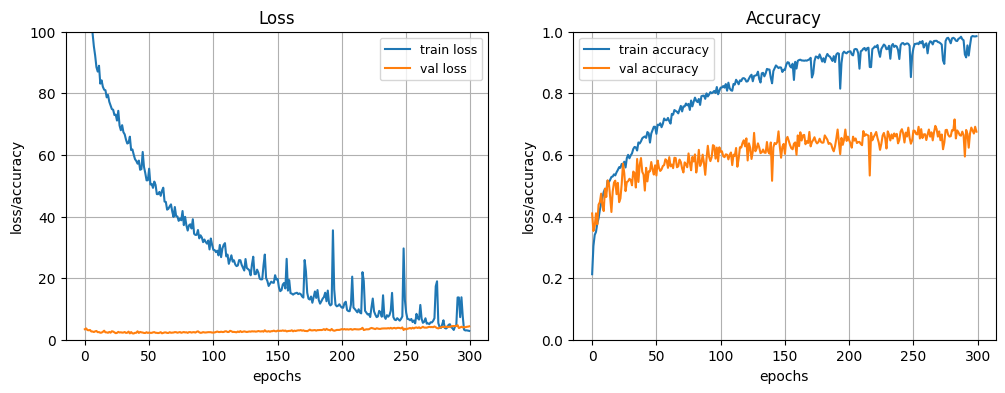

In [ ]:
viz_loss_acc(epochs, t_loss, v_loss, t_acc, v_acc)

#### 8ª Experiência

In [ ]:
# Parâmetros
epochs =300
batch_size = 256
hidden_layer_sizes = (640,640,640,640,640)
learning_rate = 0.00005

mlp = MLP(input_size=x_train_flatten.shape[1], hidden_sizes=hidden_layer_sizes, activation="relu")

loss_func = nn.CrossEntropyLoss(weight=pesos.to(device))
otim = optim.Adam(mlp.parameters(), lr=learning_rate)

# Treino
t_loss, v_loss, t_acc, v_acc, mlp = fit(x_train_flatten, y_train, flatten_data(X_val), y_val, mlp, loss_func, otim, epochs, batch_size=batch_size)

Epoch [1/300], Train Loss: 132.3609, Val Loss: 3.5948
Epoch [2/300], Train Loss: 122.5526, Val Loss: 3.4432
Epoch [3/300], Train Loss: 118.1764, Val Loss: 3.1599
Epoch [4/300], Train Loss: 115.1472, Val Loss: 3.0771
Epoch [5/300], Train Loss: 113.5540, Val Loss: 3.2237
Epoch [6/300], Train Loss: 112.3253, Val Loss: 2.7525
Epoch [7/300], Train Loss: 110.2895, Val Loss: 2.8633
Epoch [8/300], Train Loss: 107.2881, Val Loss: 3.2771
Epoch [9/300], Train Loss: 106.0297, Val Loss: 2.7813
Epoch [10/300], Train Loss: 101.5574, Val Loss: 2.7190
Epoch [11/300], Train Loss: 97.3874, Val Loss: 2.6344
Epoch [12/300], Train Loss: 95.1110, Val Loss: 2.4444
Epoch [13/300], Train Loss: 90.7114, Val Loss: 2.7231
Epoch [14/300], Train Loss: 88.6153, Val Loss: 2.6544
Epoch [15/300], Train Loss: 86.9803, Val Loss: 2.6245
Epoch [16/300], Train Loss: 84.3483, Val Loss: 2.4150
Epoch [17/300], Train Loss: 83.0945, Val Loss: 2.3464
Epoch [18/300], Train Loss: 82.6938, Val Loss: 2.4227
Epoch [19/300], Train Loss:

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(mlp, x_train_flatten, y_train)

print('\nAvaliação com os dados de teste:')
evaluate_network(mlp, flatten_data(X_test), y_test)

Avaliação com os dados de treino:
Matriz de Confusão:
 [[2491    8    0    1    0    0    0]
 [  13 2455    1   30    0    1    0]
 [  54  148 2747   18    2   29    2]
 [   0    0    0 1500    0    0    0]
 [  22   35  135    3 2735   70    0]
 [  31  109  197   13  109 3034    7]
 [   0    1    0    0    0    0 1499]]
F1 Score:  0.9403
Accuracy:  0.9406

Avaliação com os dados de teste:
Matriz de Confusão:
 [[  29   13    9    7    4    3    1]
 [   7   62   10    9    3    9    3]
 [  21   18  111    9   30   30    1]
 [   0    5    2   12    0    4    0]
 [   8   12   49    3   72   74    5]
 [  24   59  116    4  123 1007    8]
 [   0    4    2    0    3    3   17]]
F1 Score:  0.6742
Accuracy:  0.6534


### **Modelo 2 - Convolutional Neural Networks**

O modelo CNNs é uma técnica de Machine Learning especializada em reconhecimento de padrões. O seu funcionamento baseia-se em camadas convolucionais que funcionam como filtros que analisam as imagens e identificam as características mais importantes, e o mesmo tempo, ajudam a reduzir a quantidade de informação, eliminando detalhes que não são tão úteis.

Com o objetivo de experimentar várias arquiteturas, implementámos várias arquiteturas CNNs, com diferentes combinações de hiperparâmetros, de forma a avaliar o impacto de cada configuração no desempenho do modelo:

In [ ]:
class CNN1(nn.Module):
    def __init__(self, n_channels=3, num_classes=7, dropout_prob=0.5):
        super(CNN1, self).__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Camadas fully connected
        self.fc1 = nn.Linear(128*7*7, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x)) # função de ativação
        x = self.dropout(x) # camada dropout -> ajuda a prevenir o overfitting
        x = self.fc2(x)
        return x

In [ ]:
class CNN2(nn.Module):
    def __init__(self, n_channels=3, num_classes=7, dropout_prob=0.5):
        super(CNN2, self).__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Norm

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)  # Batch Norm

        # Camadas fully connected
        self.fc1 = nn.Linear(128*7*7, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)

        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class CNN3(nn.Module): # 3 camadas convolucionais
    def __init__(self, n_channels=3, num_classes=7, dropout_prob=0.5):
        super(CNN3, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 256, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        # Bloco de camadas para classificação
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

        # Camada Dropout
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
modelo_cnn = CNN3(n_channels=3, num_classes=7)
summary(modelo_cnn, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           7,168
         MaxPool2d-2          [-1, 256, 14, 14]               0
            Conv2d-3          [-1, 128, 14, 14]         295,040
         MaxPool2d-4            [-1, 128, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          73,792
         MaxPool2d-6             [-1, 64, 3, 3]               0
           Flatten-7                  [-1, 576]               0
            Linear-8                 [-1, 1024]         590,848
           Dropout-9                 [-1, 1024]               0
           Linear-10                 [-1, 1024]       1,049,600
          Dropout-11                 [-1, 1024]               0
           Linear-12                    [-1, 7]           7,175
Total params: 2,023,623
Trainable params: 2,023,623
Non-trainable params: 0
---------------------------

In [ ]:
class CNN4(nn.Module):
    def __init__(self, n_channels=3, num_classes=7, dropout_prob=0.5):
        super(CNN4, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 256, kernel_size=5, padding=3)
        self.pool1 = nn.MaxPool2d(3)

        self.conv2 = nn.Conv2d(256, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(3)

        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
class CNN5(nn.Module): # 6 camadas convolucionais
    def __init__(self, n_channels=3, num_classes=7, dropout_prob=0.5):
        super(CNN5, self).__init__()

        self.conv1 = nn.Conv2d(n_channels, 256, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=5, padding=2)

        self.pool1 = nn.MaxPool2d(2, stride=2)

        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

        self.pool2 = nn.MaxPool2d(2, stride=2)

        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        self.pool3 = nn.MaxPool2d(2, stride=2)

        self.fc1 = nn.Linear(8 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

Após os modelos estarem definidos, à semelhança do processo para o MLP, passámos à realização de experiências, onde alterámos vários parâmetros de modo a obter bons resultados.

#### Experiência 1

In [ ]:
n_channels = 3
num_classes = 7

modelo_cnn = CNN1(n_channels=n_channels, num_classes=n_classes)

criterio_loss = nn.CrossEntropyLoss(weight=pesos.to(device))
otimizador = optim.Adam(modelo_cnn.parameters(), lr=0.001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=100, batch_size=128)

Epoch [1/100], Treino Loss: 245.8530
Epoch [1/100], Validação Loss: 10.8817
Epoch [2/100], Treino Loss: 197.8495
Epoch [2/100], Validação Loss: 9.5705
Epoch [3/100], Treino Loss: 173.7406
Epoch [3/100], Validação Loss: 9.9473
Epoch [4/100], Treino Loss: 166.1802
Epoch [4/100], Validação Loss: 9.4893
Epoch [5/100], Treino Loss: 162.2565
Epoch [5/100], Validação Loss: 9.5730
Epoch [6/100], Treino Loss: 156.5691
Epoch [6/100], Validação Loss: 9.3685
Epoch [7/100], Treino Loss: 152.4524
Epoch [7/100], Validação Loss: 9.6043
Epoch [8/100], Treino Loss: 150.6653
Epoch [8/100], Validação Loss: 8.5822
Epoch [9/100], Treino Loss: 146.2298
Epoch [9/100], Validação Loss: 9.2377
Epoch [10/100], Treino Loss: 142.7469
Epoch [10/100], Validação Loss: 9.1299
Epoch [11/100], Treino Loss: 139.4084
Epoch [11/100], Validação Loss: 9.5437
Epoch [12/100], Treino Loss: 135.8407
Epoch [12/100], Validação Loss: 9.6114
Epoch [13/100], Treino Loss: 131.5670
Epoch [13/100], Validação Loss: 9.5280
Epoch [14/100], 

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2493    5    2    0    0    0    0]
 [   1 2494    0    0    3    2    0]
 [   8   50 2614    0  247   78    3]
 [   0    0    1 1498    0    1    0]
 [   3    5    8    0 2970   11    3]
 [   9   82  283    7  741 3562    9]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9159636710963667
Accuracy:  0.9164393088321832
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 10  10   5   1   5   2   0]
 [  6  34   3   0   4   5   0]
 [  5  14  45   0  29  16   1]
 [  0   7   1   3   0   1   0]
 [  1   1  12   1  74  22   0]
 [  3   6  55   4 130 470   3]
 [  0   1   1   1   0   3   8]]
F1 Score:  0.6687933131580093
Accuracy:  0.6420737786640079
Avaliação com os dados de teste:
Confusion Matrix:
 [[ 24  18   7   0  10   7   0]
 [  6  62   9   6   6  12   2]
 [ 10  26 102   1  55  26   0]
 [  1   7   4   8   0   3   0]
 [  4   9  27   1 123  57   2]
 [  6  39  79   2 254 955   6]
 [  0   2   0   1   1   3  22]]
F1 Score:  0.674

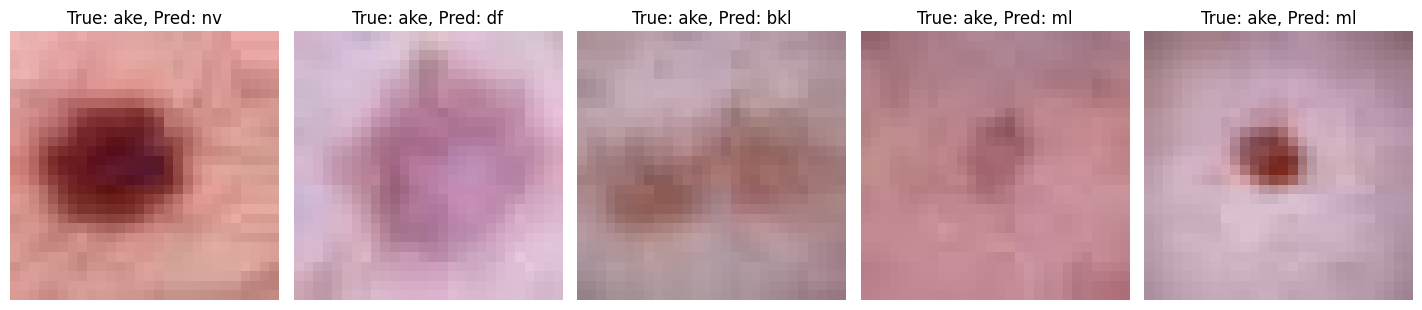

In [ ]:
cnn.eval()

with torch.no_grad():
    outputs = cnn(X_test)
    _, predicted = torch.max(outputs.data, 1)

predicted = predicted.to("cpu")
y_pred = predicted.numpy()
y_true = y_test.numpy()

# Visualizar

labels = ['ake', 'bcc' , 'bkl', 'df', 'ml', 'nv', 'vas']

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 7, i+1)
    plt.imshow(X_test[i].permute(1, 2, 0).numpy())
    plt.title(f'True: {labels[np.argmax(y_test[i])]}, Pred: {labels[y_pred[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Experiência 2

In [ ]:
modelo_cnn = CNN2(n_channels=n_channels, num_classes=n_classes)

criterio_loss = nn.CrossEntropyLoss(weight=pesos.to(device))
otimizador = optim.RMSprop(modelo_cnn.parameters(), lr=0.001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=150, batch_size=32)

Epoch [1/150], Treino Loss: 915.8716
Epoch [1/150], Validação Loss: 41.6409
Epoch [2/150], Treino Loss: 631.0185
Epoch [2/150], Validação Loss: 37.7681
Epoch [3/150], Treino Loss: 532.1444
Epoch [3/150], Validação Loss: 32.4718
Epoch [4/150], Treino Loss: 446.1708
Epoch [4/150], Validação Loss: 34.7332
Epoch [5/150], Treino Loss: 378.4132
Epoch [5/150], Validação Loss: 34.6401
Epoch [6/150], Treino Loss: 327.5140
Epoch [6/150], Validação Loss: 41.4999
Epoch [7/150], Treino Loss: 289.1588
Epoch [7/150], Validação Loss: 41.2713
Epoch [8/150], Treino Loss: 263.3545
Epoch [8/150], Validação Loss: 42.8032
Epoch [9/150], Treino Loss: 244.4980
Epoch [9/150], Validação Loss: 40.2698
Epoch [10/150], Treino Loss: 218.9125
Epoch [10/150], Validação Loss: 50.0611
Epoch [11/150], Treino Loss: 214.1233
Epoch [11/150], Validação Loss: 47.5990
Epoch [12/150], Treino Loss: 186.9437
Epoch [12/150], Validação Loss: 47.7228
Epoch [13/150], Treino Loss: 181.3821
Epoch [13/150], Validação Loss: 54.3216
Epoc

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2477   23    0    0    0    0    0]
 [   6 2491    0    3    0    0    0]
 [ 225  129 2622   13    9    2    0]
 [   2    6    0 1492    0    0    0]
 [  53   25   19    3 2886   14    0]
 [ 154  145  197   21  192 3979    5]
 [   0    1    1    0    0    0 1498]]
F1 Score:  0.9328607913192962
Accuracy:  0.9332370406034345
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 14   9   3   2   3   2   0]
 [  6  35   4   0   3   4   0]
 [ 16  20  38   2  12  21   1]
 [  4   2   1   5   0   0   0]
 [ 13   2  19   1  47  29   0]
 [ 30  49  45   1  61 483   2]
 [  2   2   0   1   0   2   7]]
F1 Score:  0.6571445383824635
Accuracy:  0.6271186440677966
Avaliação com os dados de teste:
Confusion Matrix:
 [[ 35  22   3   0   4   2   0]
 [ 19  66   8   1   3   5   1]
 [ 29  36  88   5  32  30   0]
 [  3   8   2   9   0   1   0]
 [ 19  11  33   3  91  66   0]
 [ 69  62  79   7 139 979   6]
 [  2   5   0   0   2   2  18]]
F1 Score:  0.670

#### Experiência 3

In [ ]:
modelo_cnn = CNN3(n_channels=n_channels, num_classes=n_classes)

criterio_loss = nn.CrossEntropyLoss(weight=pesos.to(device))
otimizador = optim.Adam(modelo_cnn.parameters(), lr=0.001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=40, batch_size=128)

Epoch [1/40], Treino Loss: 232.6522
Epoch [1/40], Validação Loss: 10.0539
Epoch [2/40], Treino Loss: 163.6898
Epoch [2/40], Validação Loss: 8.7854
Epoch [3/40], Treino Loss: 133.4308
Epoch [3/40], Validação Loss: 8.6054
Epoch [4/40], Treino Loss: 112.4538
Epoch [4/40], Validação Loss: 8.5777
Epoch [5/40], Treino Loss: 94.0620
Epoch [5/40], Validação Loss: 8.9245
Epoch [6/40], Treino Loss: 79.3916
Epoch [6/40], Validação Loss: 8.8261
Epoch [7/40], Treino Loss: 69.7594
Epoch [7/40], Validação Loss: 9.2245
Epoch [8/40], Treino Loss: 60.4796
Epoch [8/40], Validação Loss: 8.9861
Epoch [9/40], Treino Loss: 54.6921
Epoch [9/40], Validação Loss: 9.7174
Epoch [10/40], Treino Loss: 46.6204
Epoch [10/40], Validação Loss: 9.3611
Epoch [11/40], Treino Loss: 44.7422
Epoch [11/40], Validação Loss: 9.7714
Epoch [12/40], Treino Loss: 36.8934
Epoch [12/40], Validação Loss: 9.5831
Epoch [13/40], Treino Loss: 33.0671
Epoch [13/40], Validação Loss: 10.6265
Epoch [14/40], Treino Loss: 30.2691
Epoch [14/40],

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2500    0    0    0    0    0    0]
 [   0 2495    1    4    0    0    0]
 [   0    0 2998    0    0    2    0]
 [   0    0    0 1500    0    0    0]
 [   0    0    1    0 2997    2    0]
 [  13   25  123    7  193 4322   10]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9794451010017041
Accuracy:  0.9796180388380678
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 10   4   8   4   4   2   1]
 [  5  26   9   2   4   5   1]
 [  6  12  52   1  15  24   0]
 [  3   4   1   2   1   1   0]
 [  3   1   9   1  69  27   1]
 [  4  11  39   1  78 532   6]
 [  0   0   1   2   1   1   9]]
F1 Score:  0.7119134444143125
Accuracy:  0.6979062811565304
Avaliação com os dados de teste:
Confusion Matrix:
 [[  30   12   10    2    6    5    1]
 [   7   49   17    4    6   16    4]
 [  15   13  111    4   35   40    2]
 [   2    3    1   12    1    3    1]
 [  13    7   31    3  100   66    3]
 [  12   30   68    5  154 1059   13]
 [   0

#### Experiência 4

In [ ]:
modelo_cnn = CNN3(n_channels=3, num_classes=7)

criterio_loss = nn.CrossEntropyLoss(weight=pesos.to(device))
otimizador = optim.RMSprop(modelo_cnn.parameters(), lr=0.001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=100, batch_size=128)

Epoch [1/100], Train Loss: 299.0816, Val Loss: 5.8688
Epoch [2/100], Train Loss: 222.7216, Val Loss: 6.3562
Epoch [3/100], Train Loss: 187.8299, Val Loss: 4.6869
Epoch [4/100], Train Loss: 161.2325, Val Loss: 4.3210
Epoch [5/100], Train Loss: 148.6222, Val Loss: 4.5919
Epoch [6/100], Train Loss: 132.6751, Val Loss: 4.0092
Epoch [7/100], Train Loss: 120.3059, Val Loss: 4.9601
Epoch [8/100], Train Loss: 104.0274, Val Loss: 4.2801
Epoch [9/100], Train Loss: 97.1013, Val Loss: 4.8161
Epoch [10/100], Train Loss: 84.9983, Val Loss: 4.5176
Epoch [11/100], Train Loss: 72.8907, Val Loss: 5.0227
Epoch [12/100], Train Loss: 72.8614, Val Loss: 6.0937
Epoch [13/100], Train Loss: 62.2748, Val Loss: 5.5159
Epoch [14/100], Train Loss: 57.2173, Val Loss: 4.9172
Epoch [15/100], Train Loss: 51.3047, Val Loss: 5.2231
Epoch [16/100], Train Loss: 49.3296, Val Loss: 5.5091
Epoch [17/100], Train Loss: 45.5041, Val Loss: 4.6295
Epoch [18/100], Train Loss: 58.5710, Val Loss: 5.0626
Epoch [19/100], Train Loss: 3

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2500    0    0    0    0    0    0]
 [   0 2500    0    0    0    0    0]
 [   0    4 2988    1    0    6    1]
 [   0    0    0 1500    0    0    0]
 [   0    0    0    0 2999    1    0]
 [  11   12   43    3  115 4506    3]
 [   0    0    0    0    0    0 1500]]
F1 Score:  0.9892670590191105
Accuracy:  0.989300807789012
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 14   3   5   0   5   6   0]
 [  7  32   3   1   2   7   0]
 [  7  12  42   1  19  29   0]
 [  2   4   1   4   1   0   0]
 [  3   2   4   1  57  43   1]
 [  2   7  23   0  76 557   6]
 [  1   1   1   1   0   2   8]]
F1 Score:  0.7172341848851325
Accuracy:  0.711864406779661
Avaliação com os dados de teste:
Confusion Matrix:
 [[  31   14    9    0    6    5    1]
 [  10   58    8    3    6   18    0]
 [  15   18   93    1   35   58    0]
 [   3    6    0    6    1    7    0]
 [   9    8   20    2  105   76    3]
 [   7   30   58    1  142 1089   14]
 [   0  

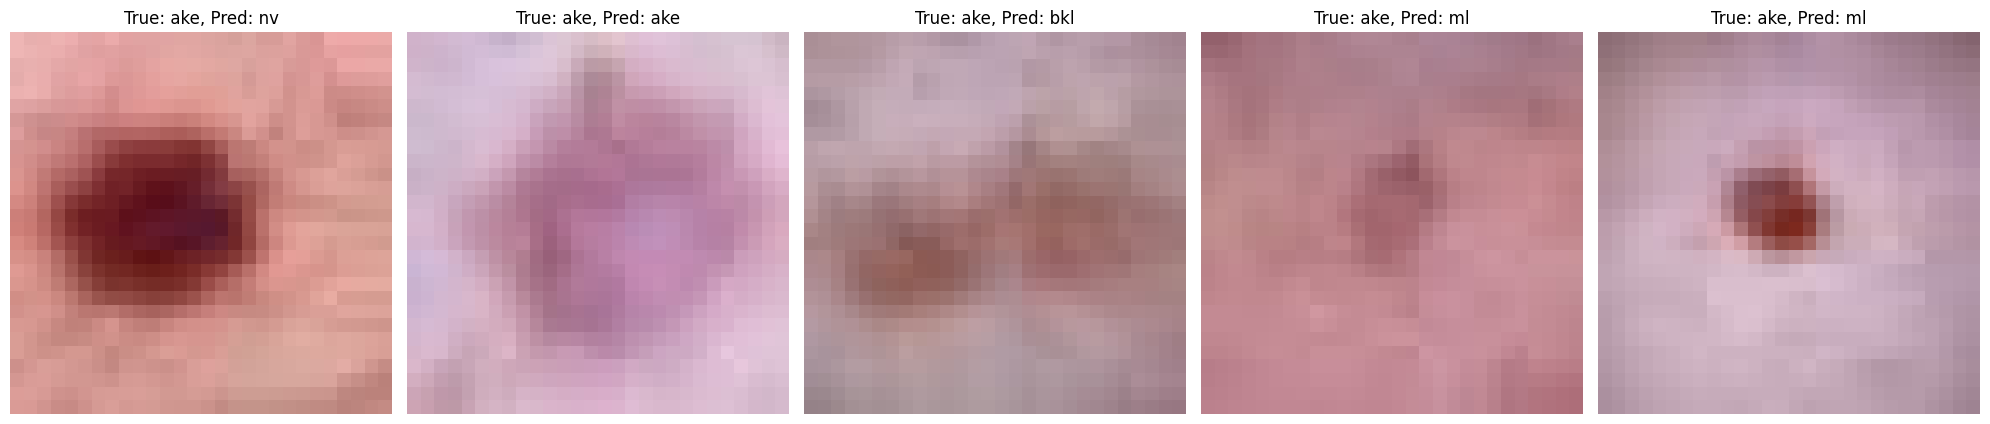

In [ ]:
cnn.eval()

with torch.no_grad():
    outputs = cnn(X_test)
    _, predicted = torch.max(outputs.data, 1)

predicted = predicted.to("cpu")
y_pred = predicted.numpy()
y_true = y_test.numpy()

# Visualizar

labels = ['ake', 'bcc' , 'bkl', 'df', 'ml', 'nv', 'vas']

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].permute(1, 2, 0).numpy())
    plt.title(f'True: {labels[np.argmax(y_test[i])]}, Pred: {labels[y_pred[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

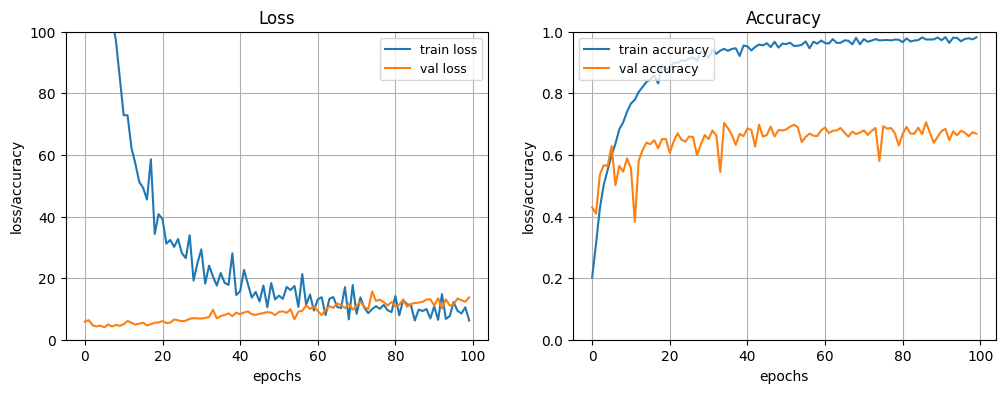

In [ ]:
viz_loss_acc(100, t_loss, v_loss, t_acc, v_acc)

#### Experiência 5

In [ ]:
modelo_cnn = CNN4(n_channels=n_channels, num_classes=n_classes)

criterio_loss = nn.MultiMarginLoss(weight=pesos.to(device))
otimizador = optim.Adam(modelo_cnn.parameters(), lr=0.0001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=50, batch_size=128)

Epoch [1/50], Treino Loss: 755.0859
Epoch [1/50], Validação Loss: 31.1234
Epoch [2/50], Treino Loss: 573.4086
Epoch [2/50], Validação Loss: 25.2198
Epoch [3/50], Treino Loss: 473.0807
Epoch [3/50], Validação Loss: 19.6214
Epoch [4/50], Treino Loss: 418.2453
Epoch [4/50], Validação Loss: 19.4205
Epoch [5/50], Treino Loss: 391.0505
Epoch [5/50], Validação Loss: 17.0702
Epoch [6/50], Treino Loss: 361.0765
Epoch [6/50], Validação Loss: 17.2816
Epoch [7/50], Treino Loss: 341.6751
Epoch [7/50], Validação Loss: 17.5600
Epoch [8/50], Treino Loss: 323.9117
Epoch [8/50], Validação Loss: 15.9043
Epoch [9/50], Treino Loss: 310.3021
Epoch [9/50], Validação Loss: 15.7168
Epoch [10/50], Treino Loss: 301.1714
Epoch [10/50], Validação Loss: 15.6918
Epoch [11/50], Treino Loss: 285.8848
Epoch [11/50], Validação Loss: 14.2006
Epoch [12/50], Treino Loss: 281.1934
Epoch [12/50], Validação Loss: 15.4438
Epoch [13/50], Treino Loss: 270.5607
Epoch [13/50], Validação Loss: 15.6479
Epoch [14/50], Treino Loss: 26

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2231  157   29   39   33   11    0]
 [ 205 2058   48   89   45   23   32]
 [ 241  152 1823   32  474  256   22]
 [  16   46    5 1432    0    1    0]
 [  79   45  330   11 2288  231   16]
 [  49   87  282   28 1014 3170   63]
 [   0    2    0    0    0    8 1490]]
F1 Score:  0.7740446215294672
Accuracy:  0.7752634676081955
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 16   9   2   1   4   1   0]
 [ 12  31   4   0   2   3   0]
 [ 13  11  47   0  29   9   1]
 [  2   3   1   6   0   0   0]
 [  4   0  10   1  80  14   2]
 [  4  12  48   2 152 442  11]
 [  0   2   0   0   1   2   9]]
F1 Score:  0.6636482069036035
Accuracy:  0.6291126620139581
Avaliação com os dados de teste:
Confusion Matrix:
 [[ 40   9   5   1   5   5   1]
 [ 22  55   7   2   7   2   8]
 [ 27  15 100   4  52  21   1]
 [  3   5   1  11   0   3   0]
 [ 12   7  21   4 151  22   6]
 [ 20  36  68   8 300 888  21]
 [  0   2   0   0   1   1  25]]
F1 Score:  0.668

#### Experiência 6

In [ ]:
modelo_cnn = CNN5(n_channels=n_channels, num_classes=n_classes)

criterio_loss = nn.CrossEntropyLoss(weight=pesos.to(device))
otimizador = optim.Adam(modelo_cnn.parameters(), lr=0.001)

# Treino
t_loss, v_loss, t_acc, v_acc, cnn = fit(X_train, y_train, X_val, y_val, modelo_cnn, criterio_loss, otimizador, n_epochs=50, batch_size=128)

Epoch [1/50], Treino Loss: 245.7731
Epoch [1/50], Validação Loss: 12.9232
Epoch [2/50], Treino Loss: 205.6584
Epoch [2/50], Validação Loss: 13.1634
Epoch [3/50], Treino Loss: 171.2072
Epoch [3/50], Validação Loss: 10.1838
Epoch [4/50], Treino Loss: 157.0155
Epoch [4/50], Validação Loss: 9.4731
Epoch [5/50], Treino Loss: 140.7941
Epoch [5/50], Validação Loss: 8.5776
Epoch [6/50], Treino Loss: 133.9154
Epoch [6/50], Validação Loss: 8.6565
Epoch [7/50], Treino Loss: 121.4249
Epoch [7/50], Validação Loss: 8.5105
Epoch [8/50], Treino Loss: 114.1111
Epoch [8/50], Validação Loss: 8.1336
Epoch [9/50], Treino Loss: 106.7615
Epoch [9/50], Validação Loss: 8.2857
Epoch [10/50], Treino Loss: 97.1406
Epoch [10/50], Validação Loss: 9.9768
Epoch [11/50], Treino Loss: 94.5254
Epoch [11/50], Validação Loss: 8.6509
Epoch [12/50], Treino Loss: 88.6140
Epoch [12/50], Validação Loss: 8.4477
Epoch [13/50], Treino Loss: 86.8560
Epoch [13/50], Validação Loss: 9.0626
Epoch [14/50], Treino Loss: 83.0623
Epoch [1

In [ ]:
print('Avaliação com os dados de treino:')
evaluate_network(cnn, X_train, y_train)

print('Avaliação com os dados de validação:')
evaluate_network(cnn, X_val, y_val)

print('Avaliação com os dados de teste:')
evaluate_network(cnn, X_test, y_test)

Avaliação com os dados de treino:
Confusion Matrix:
 [[2492    7    1    0    0    0    0]
 [   6 2472   11    1    1    9    0]
 [  15    8 2852    0   92   33    0]
 [   0    1    0 1499    0    0    0]
 [  18    2   75    0 2872   32    1]
 [  37   49  343    3  793 3459    9]
 [   0    1    0    0    0    1 1498]]
F1 Score:  0.9159898698272047
Accuracy:  0.9171347563258974
Avaliação com os dados de validação:
Confusion Matrix:
 [[ 13   6   4   0   5   5   0]
 [  7  27   3   1   9   5   0]
 [  9   8  57   0  24  12   0]
 [  1   3   1   6   1   0   0]
 [  2   1  15   1  69  22   1]
 [  6  15  70   2 134 438   6]
 [  0   1   0   1   1   2   9]]
F1 Score:  0.6500609925377145
Accuracy:  0.617148554336989
Avaliação com os dados de teste:
Confusion Matrix:
 [[ 25  14  12   1  10   3   1]
 [ 14  44  18   5   8  11   3]
 [ 17   9 117   2  47  27   1]
 [  4   4   2   8   1   4   0]
 [  7   8  37   1 128  40   2]
 [ 27  25 129   3 251 897   9]
 [  0   1   0   0   3   4  21]]
F1 Score:  0.6515

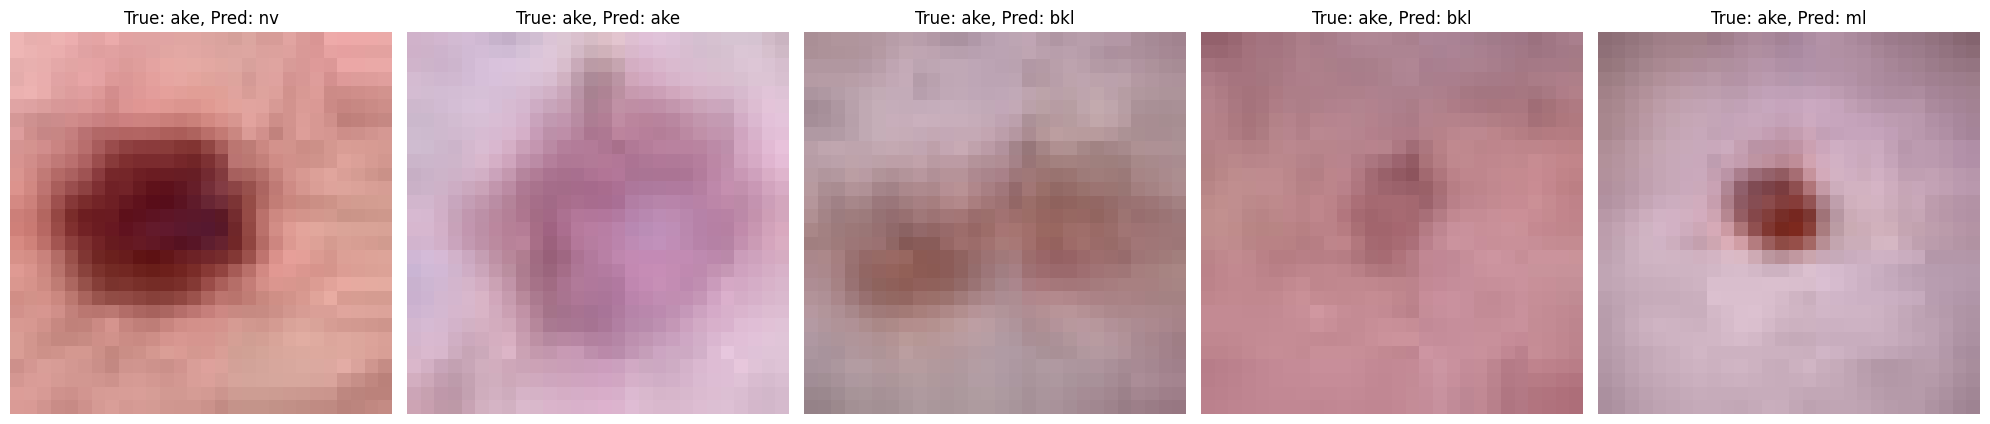

In [ ]:
cnn.eval()

# Run the model on the test data
with torch.no_grad():
    outputs = cnn(X_test)
    _, predicted = torch.max(outputs.data, 1)

predicted = predicted.to("cpu")
y_pred = predicted.numpy()
y_true = y_test.numpy()

# Visualizar

labels = ['ake', 'bcc' , 'bkl', 'df', 'ml', 'nv', 'vas']

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].permute(1, 2, 0).numpy())
    plt.title(f'True: {labels[np.argmax(y_test[i])]}, Pred: {labels[y_pred[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()